# CMPE482 Project 2

#### Ali Caner Turkmen

In the second project, we implement spectral clustering.

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from numpy.linalg import norm, solve

# cython functions
from _dist import dist_matrix

We implement the distance calculation function in Cython since it requires too much slicing. This leads to a 1000x increase in speed with respect to a naive implementation. You may see `_dist.pyx` for the Cython code.

Furthermore, we provide a short tutorial on Cython in the same directory.

In [2]:
def read_dyadic_graph_data(filepath):
    """
    :returns: numpy.array with (n_dyads, n_dims) shape
    """
    with open(filepath) as f:
        arrs = []
        for line in f.readlines():
            arrs.append(map(float, line.split(" ")))
    return np.array(arrs)

X = read_dyadic_graph_data("graphdata.txt")

In [3]:
def get_knn_matrix(D, k=5):
    """
    Get a directed KNN matrix as suggested by the assignment
    """
    nn_ix = lambda x: D[x, :].argsort()[:k+1]
    KNN = np.zeros(D.shape, dtype=np.int)
    m = D.shape[0]
    for i in range(m):
        KNN[i, nn_ix(i)] = 1
    
    KNN -= np.diag(np.ones(m, dtype=np.int))
    
    return KNN

In [4]:
def get_knn_laplacian(dist, k=5, sigma=.3):
    # calculate and symmetricize the adjacency matrix
    DG = get_knn_matrix(dist, k=k)
    A = np.array(DG + DG.T > 0, dtype=np.int)

    # We build the weight matrix W

    W = A * np.exp(.5 * (dist / sigma)**2)
    
    D = np.diag(1./np.sum(W, 1)) # inverse degree matrix

    L = np.eye(A.shape[0]) - W.dot(D)  # normalized laplacian
    
    return L, A, W # get laplacian and adjacency

Now, the assignment entails finding the second smallest eigenvalue and corresponsing eigenvector of the Laplacian. 

We take advantage of the following facts:

- $I - D^{-1}W$ is p.s.d. so its eigenvalues are nonnegative
- $I - D^{-1}W$'s lowest eigenvalue is 0. This is obvious since $(I - D^{-1}W)v = 0$ when $v = \mathbf{1}$. 

One may also consult (v. Luxburg, 2007).

We use these convenient properties to implement the following algorithm. We use inverse iterations with shifts, setting $\mu = 0$. We slowly shift $\mu$ up. At the first eigenvalue that is nonzero, we stop and take that eigenpair for spectral clustering.

As such, we save the trouble of calculating an expensive eigenvalue revealing factorization, such as Schur.

In [5]:
# just an implementation of Rayleigh quotient iteration. We do not use it
def rayleigh_quotient_iteration(A):
    N = A.shape[0]
    v = np.random.rand(N)
    v /= norm(v)
    lam = A.dot(v).dot(v)
    prev_lam = 10000
    for i in range(100):
        w = solve(A - lam * np.eye(N), v)
        v = w / norm(w)
        lam = A.dot(v).dot(v)
        print lam
        if np.abs(lam - prev_lam) < 1e-15:
            break
        prev_lam = lam
        
    return lam, v

In [6]:
# inverse iteration with shifts
def inverse_iteration(A, mu):
    N = A.shape[0]
    v = np.random.rand(N)
    v /= norm(v)
    
    prev_lam = 1e6
    
    for k in range(1000):
        w = solve(A - mu * np.eye(N), v)
        v = w / norm(w)
        lam = A.dot(v).dot(v)

        if abs(lam-prev_lam) < 1e-15:
            break
        prev_lam = lam

    return lam, v

In [7]:
# scanning for smallest eigenvalues
def small_eval_scan(X):
    for i in np.linspace(0, 1, 10001):
        lam, v = inverse_iteration(X,i)
        if abs(lam) > 1e-5:
            break
    return lam, v

In [8]:
def get_cluster_assignment(L, tau=0.):
    """
    Get cluster assignments through the second eigenvector of
    the graph Laplacian. 
    
    :param L: the graph Laplacian
    :param tau: the cluster assignment threshold
    """
    val, ev2 = small_eval_scan(L)
    
    # plot a histogram
    plt.hist(ev2,20)  # plot the histogram
    plt.show()
    
    return (ev2 > tau)

In [9]:
def project3_2014800048(points, k, sigma, tau):
    dist = dist_matrix(points)    
    L, A, W = get_knn_laplacian(dist, k=k, sigma=sigma)
    
    # We'll use networkx package to visualize the current graph
    # which seems OK
    g = nx.Graph(A)
    nx.draw(g, [(x,y) for x,y in X], node_size=20, width=.5)
    plt.show()
    
    clus_ix = get_cluster_assignment(L)
    
    nx.draw(g, [(x,y) for x,y in X], node_size=40, node_color=clus_ix, cmap="gray", width=.5)
    plt.show()
    
    return clus_ix.astype(int), W

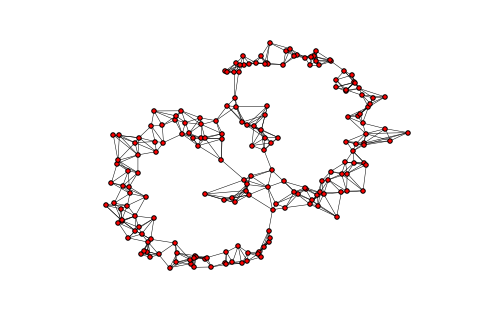

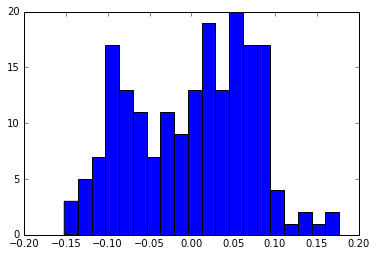

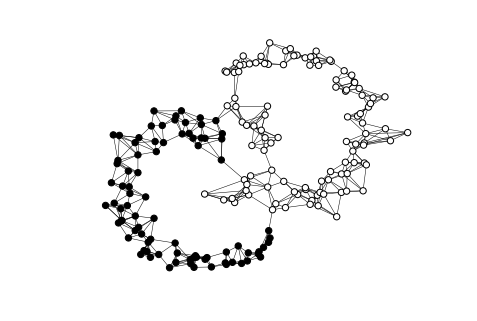

(array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]))

In [10]:
project3_2014800048(X, 5, .3, 0)